# Kaggle: House Price Prediction Challenge

In [1]:
# Import Core modules
import pandas as pd
import numpy as np

# Import modules for vizualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data into pandas dataframe
housing_train = pd.read_csv('./data/train.csv')

In [3]:
# Load test Data into pandas dataframe
housing_test = pd.read_csv('./data/test.csv')

In [4]:
housing_train.shape

(1460, 81)

In [5]:
housing_test.shape

(1459, 80)

In [6]:
# Drop the id column from both train and test data
housing_train = housing_train.drop("Id", axis=1)
housing_test = housing_test.drop("Id", axis=1)

In [7]:
len(housing_train.select_dtypes(include=['object']).columns)

43

In [8]:
housing_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

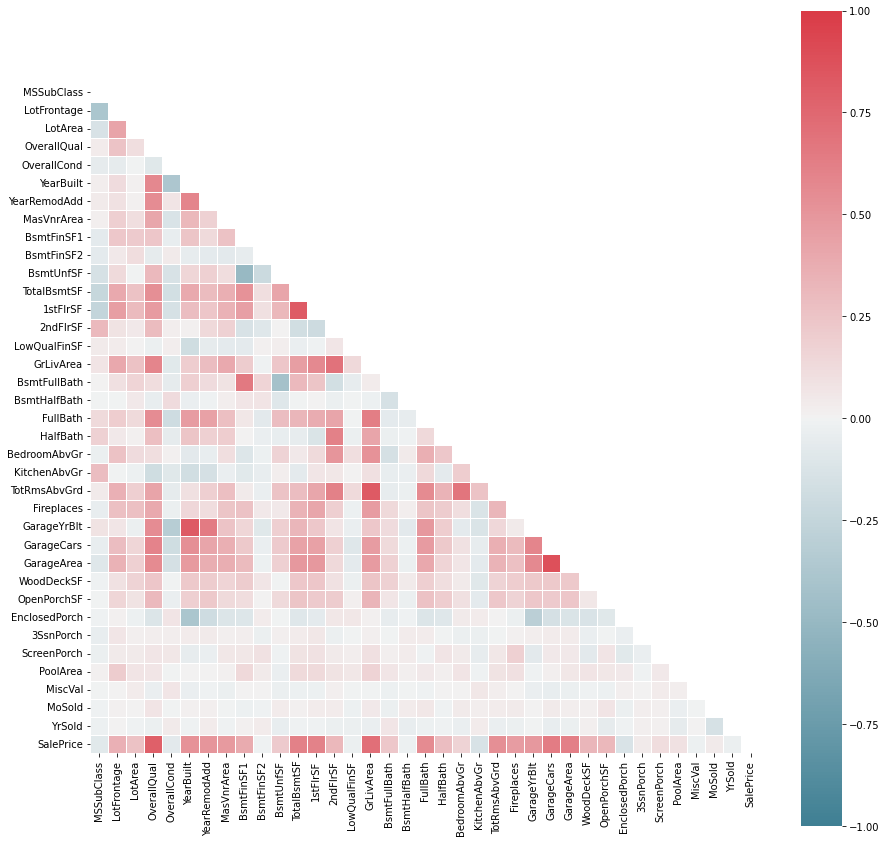

In [9]:
# Correlations 
corr = housing_train.corr()

f, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220,10,as_cmap=True), square=True, ax=ax, vmin=-1.0, vmax=1.0,
           linewidths=0.5)

In [10]:
# Sorted list of corrs among all attribs and target var SalePrice
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

## Data Preprocessing

In [11]:
housing_train.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtCond           37
BsmtQual           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
MSSubClass          0
Fireplaces          0
Functional          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
CentralAir

In [12]:
housing_test.isnull().sum().sort_values(ascending=False)

PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
FireplaceQu       730
LotFrontage       227
GarageYrBlt        78
GarageFinish       78
GarageQual         78
GarageCond         78
GarageType         76
BsmtCond           45
BsmtExposure       44
BsmtQual           44
BsmtFinType2       42
BsmtFinType1       42
MasVnrType         16
MasVnrArea         15
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
KitchenQual         1
SaleType            1
BsmtFinSF1          1
GarageCars          1
BsmtUnfSF           1
TotalBsmtSF         1
Exterior2nd         1
Exterior1st         1
GarageArea          1
BsmtFinSF2          1
TotRmsAbvGrd        0
KitchenAbvGr        0
Fireplaces          0
MSSubClass          0
HalfBath            0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal   

In [13]:
housing_train_processed = housing_train
housing_test_processed = housing_test

In [14]:
# Categorical Columns:
cat_cols_fill_node = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                      'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType',
                      'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond',
                      'MasVnrType', 'MSZoning', 'Functional', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']

# Replace missing values for categorical columns with None
for cat in cat_cols_fill_node:
    housing_train_processed[cat] = housing_train_processed[cat].fillna('None')
    housing_test_processed[cat] = housing_test_processed[cat].fillna('None')


    
# Group by neighbourhood and fill in missing value by the median Lotfrontage of all the neighborhood
housing_train_processed['LotFrontage'] = housing_train_processed.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
housing_test_processed['LotFrontage'] = housing_test_processed.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# Garage: GarageYrBlt, GarageArea are GarageCars, these are numerical columns, replace with zero
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']:
    housing_train_processed[col] = housing_train_processed[col].fillna(int(0))
    housing_test_processed[col] = housing_test_processed[col].fillna(int(0))
    
# MasVnrArea : Replace with 0
housing_train_processed['MasVnrArea'] = housing_train_processed['MasVnrArea'].fillna(int(0))
housing_test_processed['MasVnrArea'] = housing_test_processed['MasVnrArea'].fillna(int(0))

# Use the mode value for Electrical and TotalBsmtSF
housing_train_processed['Electrical'] = housing_train_processed['Electrical'].fillna(housing_train_processed['Electrical']).mode()[0]
housing_test_processed['Electrical'] = housing_test_processed['Electrical'].fillna(housing_test_processed['Electrical']).mode()[0]
housing_test_processed['TotalBsmtSF'] = housing_test_processed['TotalBsmtSF'].fillna(housing_test_processed['TotalBsmtSF']).mode()[0]

# There is no need of Utilities so let's just drop this column
housing_train_processed = housing_train_processed.drop(['Utilities'], axis=1)
housing_test_processed = housing_test_processed.drop(['Utilities'], axis=1)

In [15]:
# Get the count again to verify that we do not have any more missing value
housing_train_processed.isnull().apply(sum).max()

0

In [16]:
housing_test_processed.isnull().apply(sum).max()

0

## Dealing with Outliers

In [17]:
num_attribues_train = housing_train_processed.select_dtypes(exclude='object')
num_attribues_test = housing_test_processed.select_dtypes(exclude='object')

high_quant_train = housing_train_processed.quantile(0.999)
high_quant_test = housing_test_processed.quantile(0.999)

for i in num_attribues_train.columns:
    housing_train_processed = housing_train_processed.drop(housing_train_processed[i][housing_train_processed[i]>high_quant_train[i]].index)
for i in num_attribues_test.columns:
    housing_test_processed = housing_test_processed.drop(housing_test_processed[i][housing_test_processed[i]>high_quant_test[i]].index)

In [18]:
housing_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1422 non-null   int64  
 1   MSZoning       1422 non-null   object 
 2   LotFrontage    1422 non-null   float64
 3   LotArea        1422 non-null   int64  
 4   Street         1422 non-null   object 
 5   Alley          1422 non-null   object 
 6   LotShape       1422 non-null   object 
 7   LandContour    1422 non-null   object 
 8   LotConfig      1422 non-null   object 
 9   LandSlope      1422 non-null   object 
 10  Neighborhood   1422 non-null   object 
 11  Condition1     1422 non-null   object 
 12  Condition2     1422 non-null   object 
 13  BldgType       1422 non-null   object 
 14  HouseStyle     1422 non-null   object 
 15  OverallQual    1422 non-null   int64  
 16  OverallCond    1422 non-null   int64  
 17  YearBuilt      1422 non-null   int64  
 18  YearRemo

In [19]:
housing_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1423 entries, 0 to 1458
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1423 non-null   int64  
 1   MSZoning       1423 non-null   object 
 2   LotFrontage    1423 non-null   float64
 3   LotArea        1423 non-null   int64  
 4   Street         1423 non-null   object 
 5   Alley          1423 non-null   object 
 6   LotShape       1423 non-null   object 
 7   LandContour    1423 non-null   object 
 8   LotConfig      1423 non-null   object 
 9   LandSlope      1423 non-null   object 
 10  Neighborhood   1423 non-null   object 
 11  Condition1     1423 non-null   object 
 12  Condition2     1423 non-null   object 
 13  BldgType       1423 non-null   object 
 14  HouseStyle     1423 non-null   object 
 15  OverallQual    1423 non-null   int64  
 16  OverallCond    1423 non-null   int64  
 17  YearBuilt      1423 non-null   int64  
 18  YearRemo

## Dealing with Correlated Attributes

In [20]:
# Remove highly correlated attributes
attributes_drop = ['MiscVal', 'MoSold', 'YrSold', 'BsmtFinSF2', 'BsmtHalfBath', 'MSSubClass',
                   'GarageArea', 'GarageYrBlt', '3SsnPorch']

housing_train_processed = housing_train_processed.drop(attributes_drop, axis=1)
housing_test_processed = housing_test_processed.drop(attributes_drop, axis=1)

## Handle text and categorical attributes

In [21]:
# Transforming cat variables
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_train_processed_1hot = cat_encoder.fit_transform(housing_train_processed)
housing_test_processed_1hot = cat_encoder.fit_transform(housing_test_processed)

In [22]:
housing_test_processed_1hot

<1423x6102 sparse matrix of type '<class 'numpy.float64'>'
	with 98187 stored elements in Compressed Sparse Row format>

In [23]:
housing_train_processed_1hot

<1422x7333 sparse matrix of type '<class 'numpy.float64'>'
	with 99540 stored elements in Compressed Sparse Row format>

# Data Transformation : Pipeline

In [24]:
# Numerical Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# separate features and Target variable in the train set
housing_train_X = housing_train_processed.drop('SalePrice', axis=1)
housing_train_y = housing_train_processed['SalePrice'].copy()

# Separate numerical and Categorical attributes in lists
train_num_attributes = housing_train_X.select_dtypes(exclude='object')
train_cat_attributes = housing_train_X.select_dtypes(include='object')
test_num_attributes = housing_test_processed.select_dtypes(exclude='object')
test_cat_attributes = housing_test_processed.select_dtypes(include='object')

train_num_attribs = list(train_num_attributes)
train_cat_attribs = list(train_cat_attributes)
test_num_attribs = list(test_num_attributes)
test_cat_attribs = list(test_cat_attributes)

In [25]:
# Numerical pipelines to impute any missing value with median amd scale attributes
num_pipeline_train = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
num_pipeline_test = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

In [26]:
# using num pipeline
full_pipeline_train = ColumnTransformer([
    ("num", num_pipeline_train, train_num_attribs),
    ("cat", OneHotEncoder(), train_cat_attribs),
])

full_pipeline_test = ColumnTransformer([
    ("num", num_pipeline_test, test_num_attribs),
    ("cat", OneHotEncoder(), test_cat_attribs),
])

In [27]:
housing_train_y.describe()

count      1422.000000
mean     178405.042897
std       74506.926127
min       35311.000000
25%      129600.000000
50%      161500.000000
75%      211750.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [28]:
# Apply log transform to SalePrice
housing_train_y_prepared = np.log(housing_train_y)

In [29]:
housing_train_y_prepared.describe()

count    1422.000000
mean       12.014792
std         0.389594
min        10.471950
25%        11.772207
50%        11.992260
75%        12.263160
max        13.323927
Name: SalePrice, dtype: float64

In [30]:
# Run the transformation pipeline on all other attributes in train and test sets
housing_train_X_prepared = full_pipeline_train.fit_transform(housing_train_X)
housing_test_prepared = full_pipeline_test.fit_transform(housing_test_processed)

In [31]:
housing_train_X_prepared

<1422x281 sparse matrix of type '<class 'numpy.float64'>'
	with 98118 stored elements in Compressed Sparse Row format>

In [32]:
housing_test_prepared

<1423x276 sparse matrix of type '<class 'numpy.float64'>'
	with 96764 stored elements in Compressed Sparse Row format>

## Create ML Model

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing_train_X_prepared, housing_train_y_prepared, test_size=0.2, random_state=7)

In [34]:
# Inverse of log to change the SalePrice back to original : Invert the log-transformed value
def inv_y(transformed_y):
    return np.exp(transformed_y)

In [35]:
# Testing on LinearRegression
# import modules
from sklearn.linear_model import LinearRegression

# Train the model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on test data
print("Accuracy%:", model.score(X_test, y_test)*100)

Accuracy%: 89.54551604981937


In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Model: Random Forest. Define the model. ==============================================
rf_model = RandomForestRegressor(random_state=5)
rf_model.fit(X_train, y_train)

rf_val_predictions = rf_model.predict(X_test)
rf_val_rmse = mean_squared_error(inv_y(rf_val_predictions), inv_y(y_test))
rf_val_rmse = np.sqrt(rf_val_rmse)
rf_score = rf_model.score(X_test, y_test)*100

In [37]:
print(rf_val_rmse)

30491.94002826018


In [38]:
print(rf_score)

86.27190634165623


## Evaluation using Cross-Validation

In [39]:
from sklearn.model_selection import cross_val_score

# Perform K fold cross-validation, where K=10
scores = cross_val_score(rf_model, X_train, y_train,
                        scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())
    
display_scores(rf_rmse_scores)

Scores:  [0.12269256 0.16392273 0.10897077 0.15835138 0.12002098 0.1320601
 0.13236695 0.1120954  0.14308715 0.13295409]
Mean:  0.13265221089033558
Standard Deviation:  0.017291151911241025


In [40]:
import joblib

# Save the model
joblib.dump(rf_model, "Kaggle_RF_model.pkl")

['Kaggle_RF_model.pkl']

## Fine Tuning the model

In [41]:
from sklearn.model_selection import GridSearchCV

# Define the parameters for exploraion
param_grid = [
    {'n_estimators': [10, 50, 100, 150], 'max_features': [10, 20, 30, 40, 50, 100, 150]},
    {'bootstrap': [False], 'n_estimators': [10, 50, 100, 150], 'max_features': [10, 20, 30, 40, 50, 100, 150]},
]

# The model for whcich we are finding params values
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                          return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [10, 20, 30, 40, 50, 100, 150],
                          'n_estimators': [10, 50, 100, 150]},
                         {'bootstrap': [False],
                          'max_features': [10, 20, 30, 40, 50, 100, 150],
                          'n_estimators': [10, 50, 100, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [42]:
grid_search.best_params_

{'max_features': 100, 'n_estimators': 150}

In [43]:
grid_search.best_estimator_

RandomForestRegressor(max_features=100, n_estimators=150)

## Evaluate using the best params

In [44]:
rf_model_final = RandomForestRegressor(bootstrap=False, max_features=100, n_estimators=100, random_state=5)

rf_model_final.fit(X_train, y_train)
rf_final_val_predictions = rf_model_final.predict(X_test)

# Get RMSE
rf_final_val_rmse = mean_squared_error(inv_y(rf_final_val_predictions), inv_y(y_test))
rf_final_val_rmse = np.sqrt(rf_final_val_rmse)
rf_final_val_rmse

29322.225678673556

In [45]:
rf_score = rf_model_final.score(X_test, y_test)*100

In [46]:
rf_score

87.5379174712693

In [47]:
# saving the new model
joblib.dump(rf_model_final, "Final_RF_model.pkl")

['Final_RF_model.pkl']

In [48]:
housing_train_X.shape

(1422, 69)

In [49]:
housing_test_processed.shape

(1423, 69)

In [50]:
housing_train_X_prepared.shape

(1422, 281)

In [51]:
housing_test_prepared.shape

(1423, 276)

# Creating a new model for kaggle submission

In [52]:
# Import Core modules
import pandas as pd
import numpy as np

# Import modules for vizualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None)
import warnings
warnings.filterwarnings('ignore')

In [53]:
train = pd.read_csv('./data/train.csv')
real_data = pd.read_csv('./data/test.csv')

In [54]:
# train = train.drop("Id", axis=1)
# real_data = real_data.drop("Id", axis=1)

In [55]:
train = train.drop(train[(train['TotalBsmtSF']>5000) & (train['SalePrice']<30000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

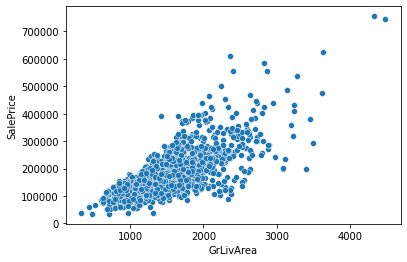

In [56]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)
plt.show()

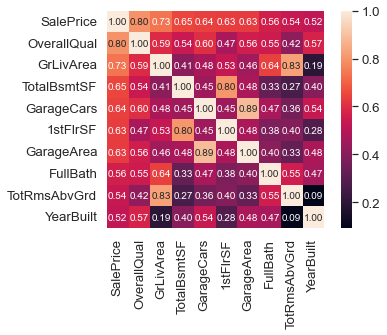

In [57]:
correlation = train.corr()
k = 10 # no of vars in heatmap
cols = correlation.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [58]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
# sns.pairplot(train[cols], size=2.5)

In [59]:
train.isnull().sum().sum()

6958

In [60]:
total = train.isnull().sum().sort_values(ascending=False)
percentage = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])

In [61]:
train = train.drop(missing_data[missing_data['Total'] > 1].index, 1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)

In [62]:
train.isnull().sum().sum()

0

In [63]:
from scipy.stats import norm
from scipy import stats
train['SalePrice'] = np.log1p(train['SalePrice'])

In [64]:
train = pd.get_dummies(train)

In [65]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score

In [68]:
scaler = StandardScaler()
X = train.drop('SalePrice', axis=1)
y = train[['SalePrice']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(1165, 220)
(292, 220)
(292, 1)
(1165, 1)


In [69]:
# linear regression
l_r = LinearRegression()
l_r.fit(X_train, y_train)
y_train_pred = l_r.predict(X_train)
y_test_pred = l_r.predict(X_test)
scorer = make_scorer(mean_squared_error, greater_is_better=False)
rmse_train = np.sqrt(-cross_val_score(l_r, X_train, y_train, scoring=scorer, cv=10))
rmse_test = np.sqrt(-cross_val_score(l_r, X_test, y_test, scoring=scorer, cv=10))
print('Mean RMSE for train set: ', rmse_train.mean())
print('Mean RMSE for test set: ', rmse_test.mean())

Mean RMSE for train set:  1010.3304266744235
Mean RMSE for test set:  0.19085142306417344
